# Single Geodesic

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

In [84]:
def SchBHGeodesicIntegrator(r0, b0, phi0):
    M = 1
    critical_b = 3*np.sqrt(3)
    
    # Metric components
    def gtt(r):
        return -(1 - (2*M)/r)
    
    def grr(r):
        return 1/(1 - (2*M)/r)
    
    # shape equation
    def dphidr(r, phi):
        with np.errstate(all='ignore'):
            numerator = b0 * np.sqrt(-grr(r)*gtt(r))/r**2
            denominator = np.sqrt(np.abs(1 + (b0**2 * gtt(r))/r**2))
            return np.sign(1 + (b0**2 * gtt(r))/r**2) * numerator/denominator 
            # np.sign is used to handle the direction of integration +1 inward -1 outward
    
    # First determine if we have a turning point
    if b0 >= critical_b:
        # find turning point
        def equation(r):
            return 1 + (b0**2 * gtt(r))/r**2
        rend = fsolve(equation, 3)[0] 
        # with initial guess 3 ; rend is made a list by taking the first solution in the array
        
        # Solve the differential equation from r0 to rend (inward)
        sol_in = solve_ivp(dphidr, [r0, rend], [phi0], 
                          rtol=1e-8, atol=1e-8, max_step=0.1,
                          dense_output=True)
        
        # Solve the differential equation from rend back out (outward)
        sol_out = solve_ivp(lambda r, phi: -dphidr(r, phi), 
                           [rend, r0], [sol_in.y[0,-1]], # the final value of the angle from sol_in
                           rtol=1e-8, atol=1e-8, max_step=0.1,
                           dense_output=True)
        
        # smooth arrays for plotting
        r_in = np.linspace(r0, rend, 1000)
        phi_in = sol_in.sol(r_in)[0]
        
        r_out = np.linspace(rend, r0, 1000)
        phi_out = sol_out.sol(r_out)[0]
        
        # Combine solutions
        r_vals = np.concatenate([r_in, r_out])
        phi_vals = np.concatenate([phi_in, phi_out])
        
    else:
        # Photon falls into black hole - integrate till just outside horizon
        rend = 2.01  # Just outside event horizon
        sol = solve_ivp(dphidr, [r0, rend], [phi0],
                       rtol=1e-8, atol=1e-8, max_step=0.1,
                       dense_output=True)
        
        r_vals = np.linspace(r0, rend, 1000)
        phi_vals = sol.sol(r_vals)[0]
    
    # Convert to Cartesian coordinates
    x_vals = r_vals * np.cos(phi_vals)
    y_vals = r_vals * np.sin(phi_vals)

    # Plotting
    plt.figure(figsize=(5,5))
    plt.plot(x_vals, y_vals, 'b-', linewidth=1.5)
    
    # Add black hole and photon sphere
    horizon = plt.Circle((0,0), 2, color='k', alpha=0.7)
    photon_sphere = plt.Circle((0,0), 3, color='gold', fill=False, 
                             linewidth=2, linestyle='--')
    plt.gca().add_patch(horizon)
    plt.gca().add_patch(photon_sphere)
    
    plt.xlim(-1*r0, 1*r0)
    plt.ylim(-1*r0, 1*r0)
    plt.gca().set_aspect('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x [M]', fontsize=12)
    plt.ylabel('y [M]', fontsize=12)
    
    if b0 >= critical_b:
        plt.title(f'Scattered Photon (b = {b0:.3f} > b_crit)', fontsize=14)
        # Mark turning point
        turn_x = rend * np.cos(phi_in[-1])
        turn_y = rend * np.sin(phi_in[-1])
        plt.scatter([turn_x], [turn_y], color='r', s=50, zorder=5)
    else:
        plt.title(f'Captured Photon (b = {b0:.3f} < b_crit)', fontsize=14)
        # Mark final point
        final_x = rend * np.cos(phi_vals[-1])
        final_y = rend * np.sin(phi_vals[-1])
        plt.scatter([final_x], [final_y], color='r', s=50, zorder=5)
    
    plt.tight_layout()
    plt.show()

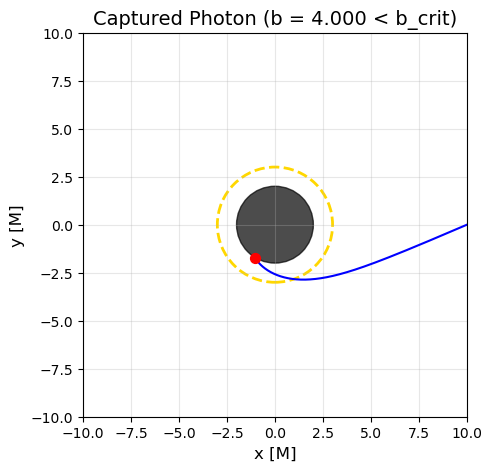

In [89]:
SchBHGeodesicIntegrator(10, 4.0, 0)   # photon captured

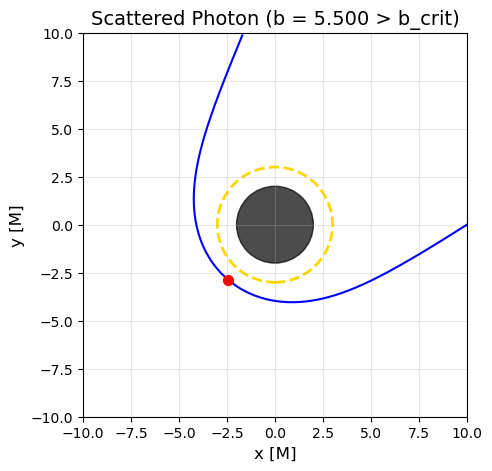

In [9]:
SchBHGeodesicIntegrator(10, 5.5, 0)   # photon captured

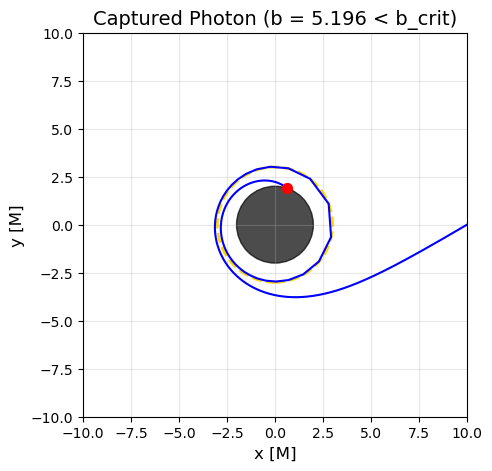

In [72]:
SchBHGeodesicIntegrator(10, 5.196, 0)   # photon captured

# Multiple Geodesics

<Figure size 1000x1000 with 0 Axes>

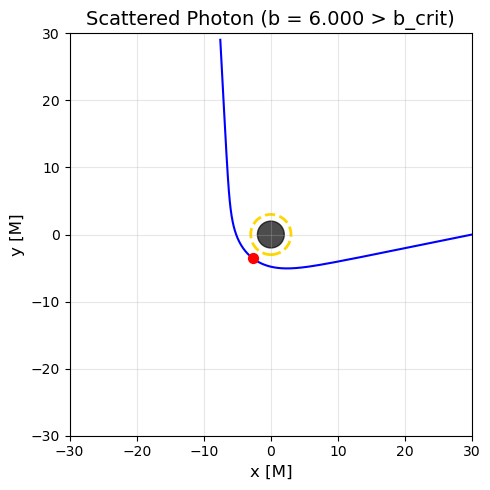

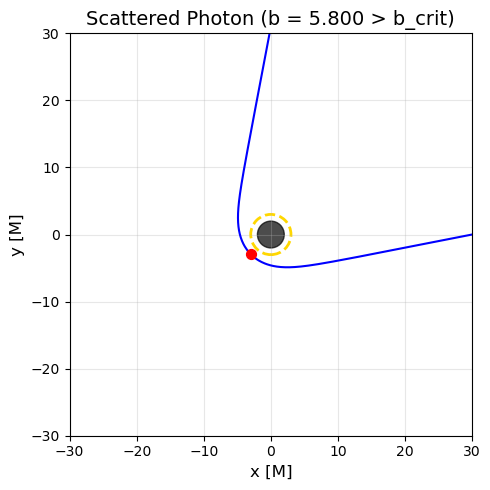

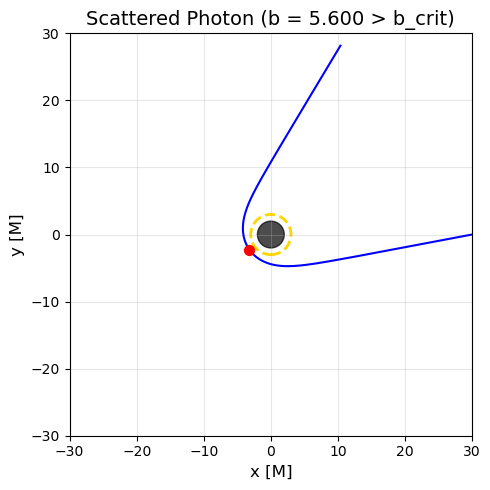

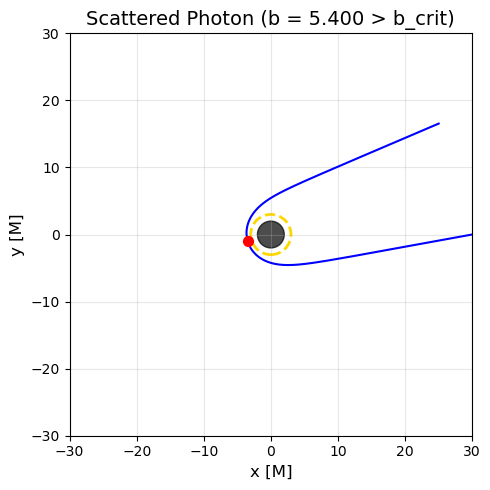

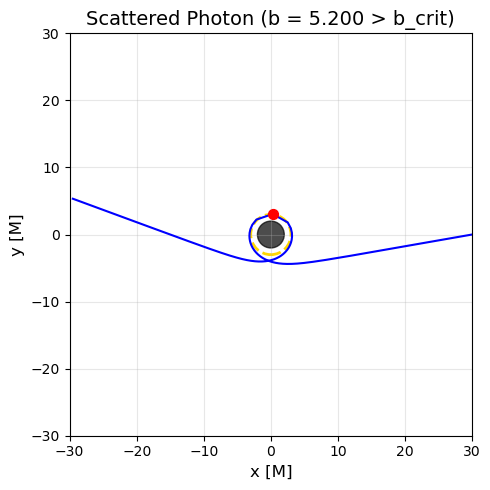

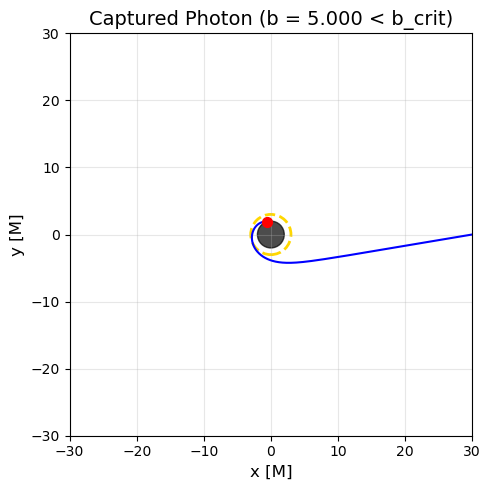

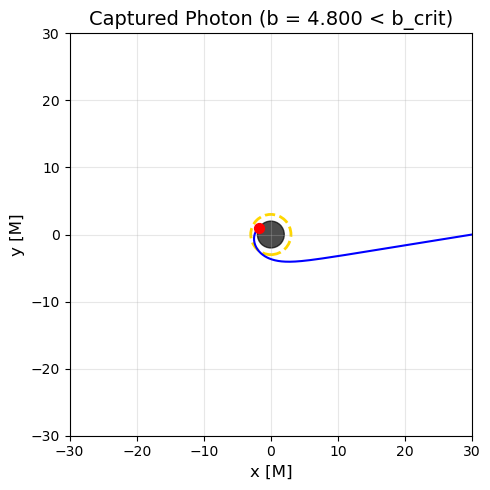

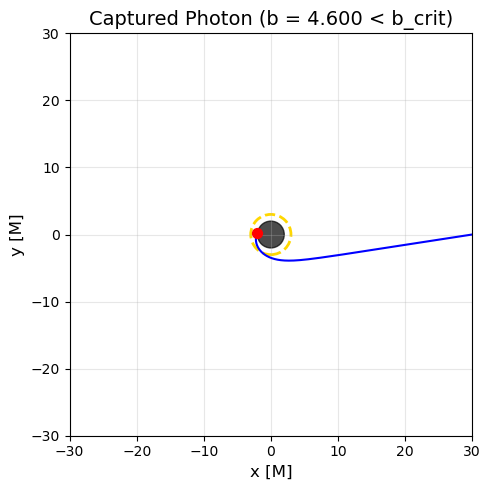

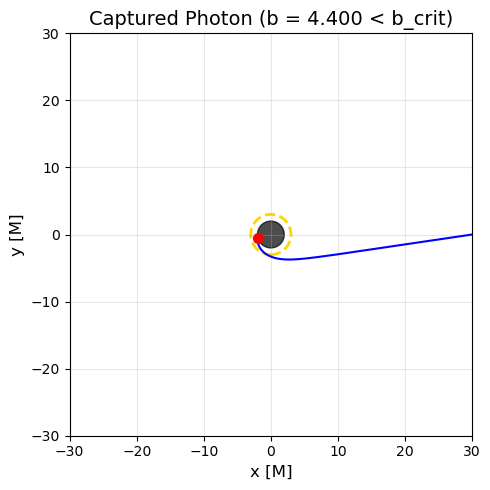

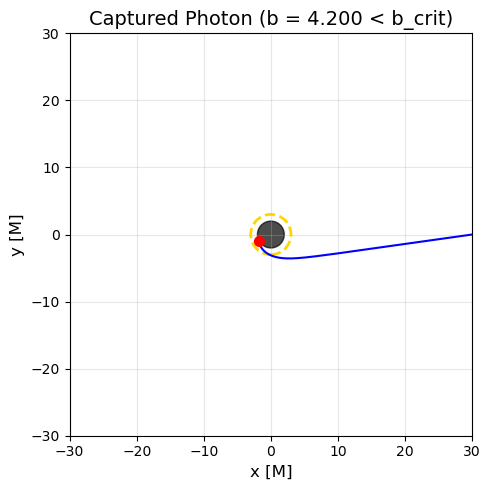

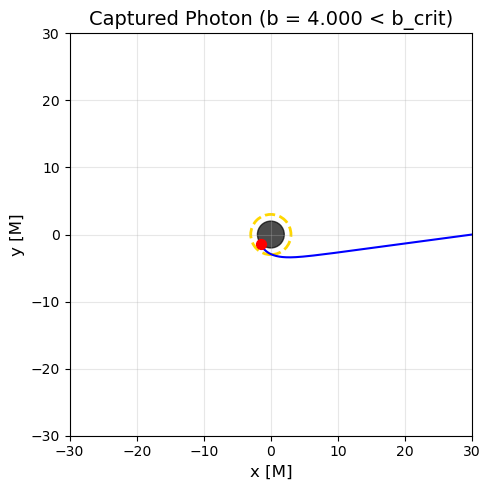

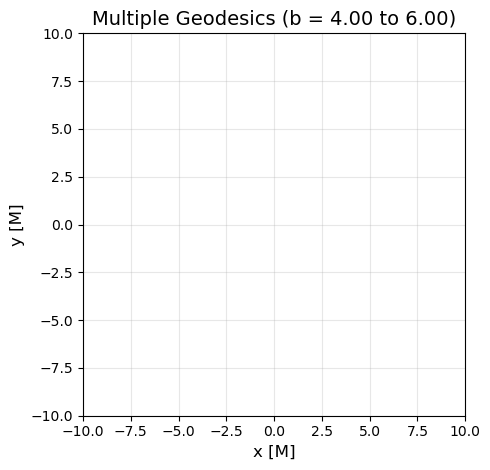

In [11]:
def SchBHManyGeodesics(r0s, b0is, bends, phi0s, Nsteps):
    epsilon = (b0is - bends)/Nsteps
    figs = []
    
    plt.figure(figsize=(10,10))
    
    # loop over many b0
    for i in range(Nsteps+1):
        b0 = b0is - i*epsilon
        SchBHGeodesicIntegrator(r0s, b0, phi0s)
    
    # Common plot settings
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.gca().set_aspect('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x [M]', fontsize=12)
    plt.ylabel('y [M]', fontsize=12)
    plt.title(f'Multiple Geodesics (b = {bends:.2f} to {b0is:.2f})', fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage:
SchBHManyGeodesics(10, 6.0, 4.0, 0, 10)

In [90]:
def SchBHGeodesicIntegrator(r0, b0, phi0, plot_individual=False):
    M = 1
    critical_b = 3*np.sqrt(3)
    
    # Metric components
    def gtt(r):
        return -(1 - (2*M)/r)
    
    def grr(r):
        return 1/(1 - (2*M)/r)
    
    # Differential equation
    def dphidr(r, phi):
        with np.errstate(all='ignore'):
            numerator = b0 * np.sqrt(-grr(r)*gtt(r))/r**2
            denominator = np.sqrt(np.abs(1 + (b0**2 * gtt(r))/r**2))
            return np.sign(1 + (b0**2 * gtt(r))/r**2) * numerator/denominator
    
    # Determine if we have a turning point
    if b0 >= critical_b:
        # find turning point
        def equation(r):
            return 1 + (b0**2 * gtt(r))/r**2
        rend = fsolve(equation, 3)[0]
        
        # Solve the differential equation from r0 to rend (inward)
        sol_in = solve_ivp(dphidr, [r0, rend], [phi0], 
                          rtol=1e-8, atol=1e-8, max_step=0.1,
                          dense_output=True)
        
        # Solve the differential equation from rend back out (outward)
        sol_out = solve_ivp(lambda r, phi: -dphidr(r, phi), [rend, r0], [sol_in.y[0,-1]], rtol=1e-8, atol=1e-8, max_step=0.1, dense_output=True)
        
        # Create smooth arrays for plotting
        r_in = np.linspace(r0, rend, 1000)
        phi_in = sol_in.sol(r_in)[0]
        
        r_out = np.linspace(rend, r0, 1000)
        phi_out = sol_out.sol(r_out)[0]
        
        # Combine solutions
        r_vals = np.concatenate([r_in, r_out])
        phi_vals = np.concatenate([phi_in, phi_out])
        
    else:
        # Photon falls into black hole - integrate till just outside horizon
        rend = 2.01  # Just outside event horizon
        sol = solve_ivp(dphidr, [r0, rend], [phi0],
                       rtol=1e-8, atol=1e-8, max_step=0.1,
                       dense_output=True)
        
        r_vals = np.linspace(r0, rend, 1000)
        phi_vals = sol.sol(r_vals)[0]
    
    # Convert to Cartesian coordinates
    x_vals = r_vals * np.cos(phi_vals)
    y_vals = r_vals * np.sin(phi_vals)

    if plot_individual:
        plt.figure(figsize=(10,10))
    
    # Plot the trajectory
    plt.plot(x_vals, y_vals, '-', linewidth=1.5)

    # modified plotting -  just choosing what to plot

    
    if plot_individual:
        plt.show()
    else:
        return x_vals, y_vals

In [91]:
# just a loop to plot many geodesics SchBHManyGeodesics
def SchBHManyGeodesics(r0s, b0is, bends, phi0s, Nsteps):
    epsilon = (b0is - bends)/Nsteps
    
    plt.figure(figsize=(5,5))

    # Create a color gradient from blue (small b) to red (large b) / plasma/rainbow/jet/coolwarm
    colors = plt.cm.coolwarm(np.linspace(0, 1, Nsteps+1))
    
    for i in range(Nsteps+1):
        b0 = b0is - i*epsilon
        x, y = SchBHGeodesicIntegrator(r0s, b0, phi0s)
        plt.plot(x, y, '-', color=colors[i], linewidth=1.5)
    
    #for i in range(Nsteps+1):
    #    b0 = b0is - i*epsilon
    #    x, y = SchBHGeodesicIntegrator(r0s, b0, phi0s)
    #    plt.plot(x, y, '-', linewidth=1.5)
    
    # Add black hole and photon sphere
    horizon = plt.Circle((0,0), 2, color='k', alpha=0.7)
    photon_sphere = plt.Circle((0,0), 3, color='gold', fill=False, 
                             linewidth=2, linestyle='--')
    plt.gca().add_patch(horizon)
    plt.gca().add_patch(photon_sphere)
    
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.gca().set_aspect('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x [M]', fontsize=12)
    plt.ylabel('y [M]', fontsize=12)
    plt.title(f'Geodesics (b = {bends:.2f} to {b0is:.2f})', fontsize=14)
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

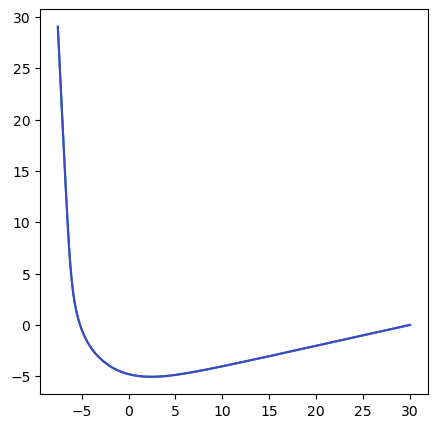

In [95]:
SchBHManyGeodesics(30, 6.0, 4.0, 0, 20) #r0s, b0is, bends, phi0s, Nsteps

# Acreetion Disk Profiles

In [61]:
from scipy.special import erf, ellipk, ellipe
from matplotlib.colors import LinearSegmentedColormap

In [62]:
def intensity_profile(r, profile_type='Novikov-Thorne', **params):
    M = 1  # Black hole mass
    r_isco = 6  # ISCO
    
    if profile_type == 'Novikov-Thorne':
        # Thin disk model (Page & Thorne 1974, Novikov & Thorne 1973)
        a = params.get('a', 0)  # Spin parameter (0 for Schwarzschild)
        r_in = params.get('r_in', r_isco)
        r_out = params.get('r_out', 20)
        norm = params.get('norm', 1.0)
        
        # Page-Thorne emissivity (simplified)
        def F(r):
            x = np.sqrt(r)
            x0 = np.sqrt(r_in)
            return norm * (3/(4*np.pi)) * (1/(r**3)) * (1 - x0/x) / (1 - 3/r)
        
        valid = (r >= r_in) & (r <= r_out)
        return np.where(valid, F(r), 0)
    
    elif profile_type == 'ISCO':
        γ, μ, σ = -2, 6, 1/4
        return np.exp(-0.5*(γ + np.arcsinh((r-μ)/σ))**2)/np.sqrt((r-μ)**2 + σ**2)
    
    elif profile_type == 'PowerLaw':
        # Simple power-law profile (Shakura-Sunyaev alpha disk)
        alpha = params.get('alpha', -2)
        norm = params.get('norm', 1.0)
        return norm * r**alpha
    
    elif profile_type == 'Exponential':
        # Exponential cutoff profile
        r0 = params.get('r0', r_isco)
        beta = params.get('beta', 1.0)
        norm = params.get('norm', 1.0)
        return norm * np.exp(-(r/r0)**beta)
    
    elif profile_type == 'GRMHD':
        # Mock GRMHD simulation profile (approximate)
        r_peak = params.get('r_peak', 8)
        width = params.get('width', 3)
        norm = params.get('norm', 1.0)
        return norm * np.exp(-(r - r_peak)**2/(2*width**2))
    
    else:
        raise ValueError(f"Unknown profile type: {profile_type}")

In [63]:
def plot_comparison_profiles():
    r = np.linspace(2, 20, 500)
    
    plt.figure(figsize=(10, 6))
    
    profiles = [
        ('Novikov-Thorne', 'red', 'Novikov-Thorne (a=0)'),
        ('PowerLaw', 'blue', r'PowerLaw ($\alpha=-2$)'),
        ('Exponential', 'green', 'Exponential (r0=6)'),
        ('GRMHD', 'purple', 'GRMHD-like'),
        ('ISCO', 'orange', 'ISCO Profile')
    ]
    
    for ptype, color, label in profiles:
        I = intensity_profile(r, ptype)
        plt.plot(r, I/I.max(), color=color, label=label, linewidth=2)
    
    plt.axvline(x=6, color='gray', linestyle='--', label='ISCO')
    plt.xlabel('Radius (r/M)', fontsize=12)
    plt.ylabel('Normalized Intensity', fontsize=12)
    plt.title('Accretion Disk Intensity Profiles', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.xlim(2, 20)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

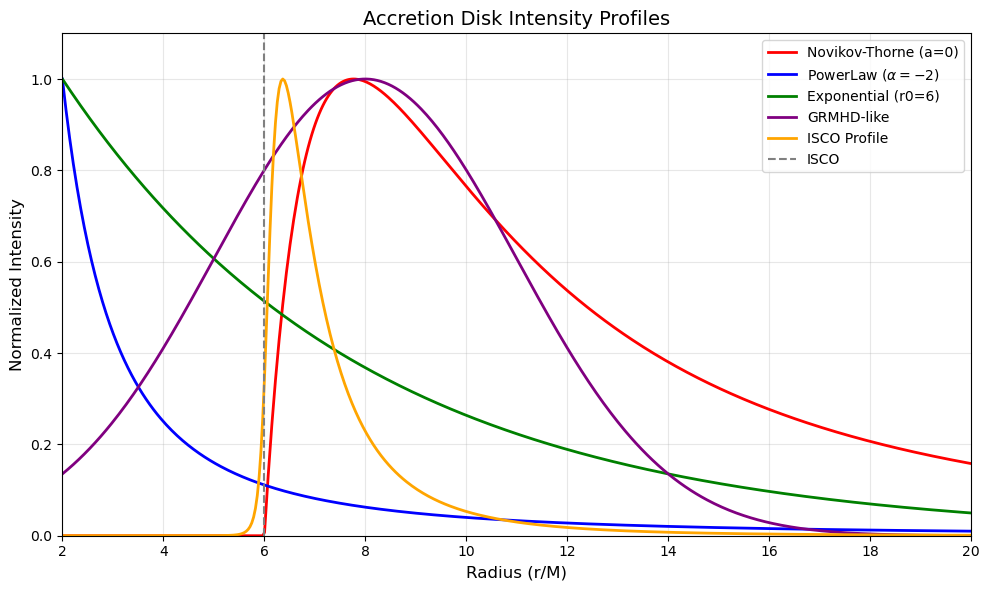

In [64]:
plot_comparison_profiles()